# Age prediction using street view images
Link: https://www.kaggle.com/code/gcdatkin/age-prediction-from-images-cnn-regression/notebook 

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

In [2]:
directories = [
    Path('/workspace/workspace/ufo-prediction/image_data_NLD'),
    Path('/workspace/workspace/ufo-prediction/image_data_ESP'),  # Add your second directory path here
    Path('/workspace/workspace/ufo-prediction/image_data_FRA')   # Add your third directory path here
]

In [3]:
filepaths = pd.Series(
    [item for directory in directories for item in directory.glob('**/*.jpg')],
    name='Filepath'
).astype(str)

def get_age_bracket(age):
    if 1900 <= age <= 1944:
        return '1900-1944'
    elif 1945 <= age <= 1969:
        return '1945-1969'
    elif 1970 <= age <= 1979:
        return '1970-1979'
    elif 1980 <= age <= 1989:
        return '1980-1989'
    elif 1990 <= age <= 1999:
        return '1990-1999'
    elif 2000 <= age <= 2009:
        return '2000-2009'
    elif 2010 <= age <= 2050:
        return '2010-2050'
    else:
        return 'Unknown'  # For ages outside the specified brackets or if age couldn't be determined


def extract_age_and_name(filepath):
    filename = os.path.basename(filepath)  # Get the filename from the filepath
    age_and_name = filename.split('.')[0]  # Split by dot and take the first part
    age = ''.join(filter(str.isdigit, age_and_name))[:4]  # Extract first 4 digits for age
    if age:  # Ensure age string is not empty
        age = int(age)
        age_bracket = get_age_bracket(age)  # Get the age bracket
    else:  # Default age if no digits found
        age_bracket = 'Unknown'
    return age_bracket

age_bracket_to_int = {
    '1900-1944': 0,
    '1945-1969': 1,
    '1970-1979': 2,
    '1980-1989': 3,
    '1990-1999': 4,
    '2000-2009': 5,
    '2010-2050': 6
}

age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
filtered_age_brackets = age_brackets[age_brackets != 'Unknown']
filtered_filepaths = filepaths[age_brackets != 'Unknown']
train_df = pd.concat([filtered_filepaths, filtered_age_brackets], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
train_df['Target'] = train_df['Age Brackets'].map(age_bracket_to_int)

In [4]:
train_df

,Filepath,Age Brackets,Target
0,/workspace/workspace/ufo-prediction/image_data...,1970-1979,2
1,/workspace/workspace/ufo-prediction/image_data...,1970-1979,2
2,/workspace/workspace/ufo-prediction/image_data...,1945-1969,1
3,/workspace/workspace/ufo-prediction/image_data...,1970-1979,2
4,/workspace/workspace/ufo-prediction/image_data...,1900-1944,0
...,...,...,...
14091,/workspace/workspace/ufo-prediction/image_data...,1900-1944,0
14092,/workspace/workspace/ufo-prediction/image_data...,1970-1979,2
14093,/workspace/workspace/ufo-prediction/image_data...,1900-1944,0
14094,/workspace/workspace/ufo-prediction/image_data...,1900-1944,0


In [5]:
directory = Path('/workspace/workspace/ufo-prediction/image_data')

In [6]:
filepaths = pd.Series(list(directory.glob(r'**/*.jpg')), name='Filepath').astype(str)
age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
filtered_age_brackets = age_brackets[age_brackets != 'Unknown']
filtered_filepaths = filepaths[age_brackets != 'Unknown']

test_df = pd.concat([filtered_filepaths, filtered_age_brackets], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
test_df['Target'] = test_df['Age Brackets'].map(age_bracket_to_int)

In [7]:
# Split into train and test set
test_df


,Filepath,Age Brackets,Target
0,/workspace/workspace/ufo-prediction/image_data...,1980-1989,3
1,/workspace/workspace/ufo-prediction/image_data...,1945-1969,1
2,/workspace/workspace/ufo-prediction/image_data...,2010-2050,6
3,/workspace/workspace/ufo-prediction/image_data...,1990-1999,4
4,/workspace/workspace/ufo-prediction/image_data...,1900-1944,0
...,...,...,...
1200,/workspace/workspace/ufo-prediction/image_data...,2010-2050,6
1201,/workspace/workspace/ufo-prediction/image_data...,1970-1979,2
1202,/workspace/workspace/ufo-prediction/image_data...,1980-1989,3
1203,/workspace/workspace/ufo-prediction/image_data...,2000-2009,5


In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Target',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Target',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Target',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 11277 validated image filenames.
Found 2819 validated image filenames.
Found 1205 validated image filenames.


# Training

In [10]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy'
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=1000,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
    ]
)

Epoch 1/1000
353/353 [==============================] - 11s 21ms/step - loss: 1.8048 - val_loss: 1.7957
Epoch 2/1000
353/353 [==============================] - 7s 20ms/step - loss: 1.7947 - val_loss: 1.7875
Epoch 3/1000
353/353 [==============================] - 7s 20ms/step - loss: 1.7916 - val_loss: 1.7924
Epoch 4/1000
353/353 [==============================] - 7s 21ms/step - loss: 1.7895 - val_loss: 1.7839
Epoch 5/1000
353/353 [==============================] - 8s 22ms/step - loss: 1.7863 - val_loss: 1.7964
Epoch 6/1000
353/353 [==============================] - 7s 19ms/step - loss: 1.7836 - val_loss: 1.7808
Epoch 7/1000
353/353 [==============================] - 7s 20ms/step - loss: 1.7807 - val_loss: 1.7811
Epoch 8/1000
353/353 [==============================] - 7s 21ms/step - loss: 1.7796 - val_loss: 1.7726
Epoch 9/1000
353/353 [==============================] - 7s 20ms/step - loss: 1.7790 - val_loss: 1.7730
Epoch 10/1000
353/353 [==============================] - 7s 21ms/step - 

# Results

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np


predicted_probs = model.predict(test_images)
predicted_classes = np.argmax(predicted_probs, axis=1)  # Convert probabilities to class labels
true_classes = test_images.labels  # Make sure these are actual labels, not one-hot encoded

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Test Accuracy: {accuracy:.5f}")

# Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
print(f"Test Precision: {precision:.5f}")
print(f"Test Recall: {recall:.5f}")
print(f"Test F1-Score: {f1:.5f}")



38/38 [==============================] - 1s 16ms/step
Test Accuracy: 0.16183
Test Precision: 0.21671
Test Recall: 0.16183
Test F1-Score: 0.09374
Confusion Matrix:
[[139  60   3   0   0   2   0]
 [ 92  36   3   0   1   0   1]
 [ 64  31   6   0   0   3   0]
 [ 48  26   2   3   1   1   0]
 [212  72  11  13   1   7   0]
 [ 91  97  10  10   1   9   3]
 [ 80  55   4   2   0   4   1]]


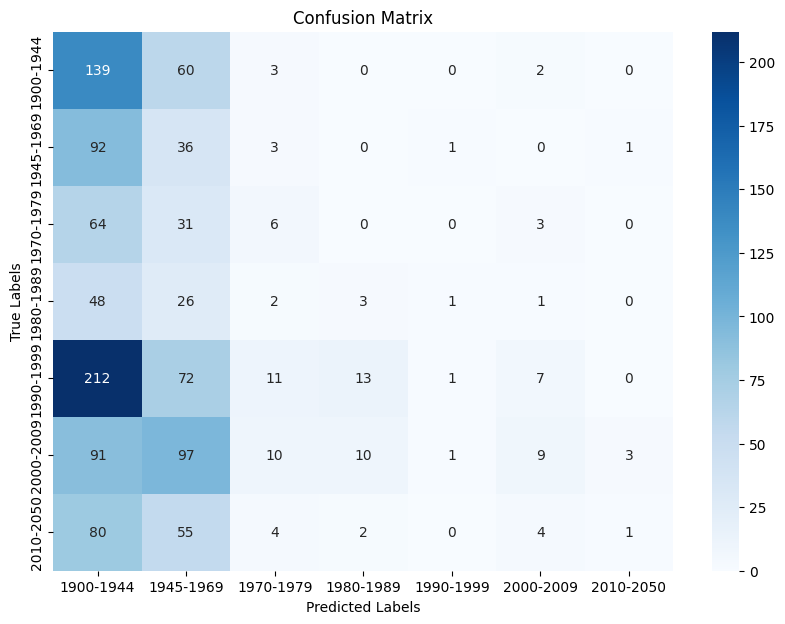

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming `true_classes` and `predicted_classes` are defined as before
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'], yticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [20]:
from sklearn.dummy import DummyClassifier
import numpy as np

dummy_stratified = DummyClassifier(strategy='stratified')
dummy_stratified.fit(np.zeros_like(true_classes), true_classes)  # X can be anything, as it's ignored
predictions_stratified = dummy_stratified.predict(np.zeros_like(true_classes))

# Calculate accuracy
accuracy_stratified = accuracy_score(true_classes, predictions_stratified)
print(f"Baseline Accuracy (Random Guessing): {accuracy_stratified:.5f}")

# Precision, Recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predictions_stratified, average='weighted')
print(f"Test Precision: {precision:.5f}")
print(f"Test Recall: {recall:.5f}")
print(f"Test F1-Score: {f1:.5f}")

Baseline Accuracy (Random Guessing): 0.16680
Test Precision: 0.16299
Test Recall: 0.16680
Test F1-Score: 0.16463


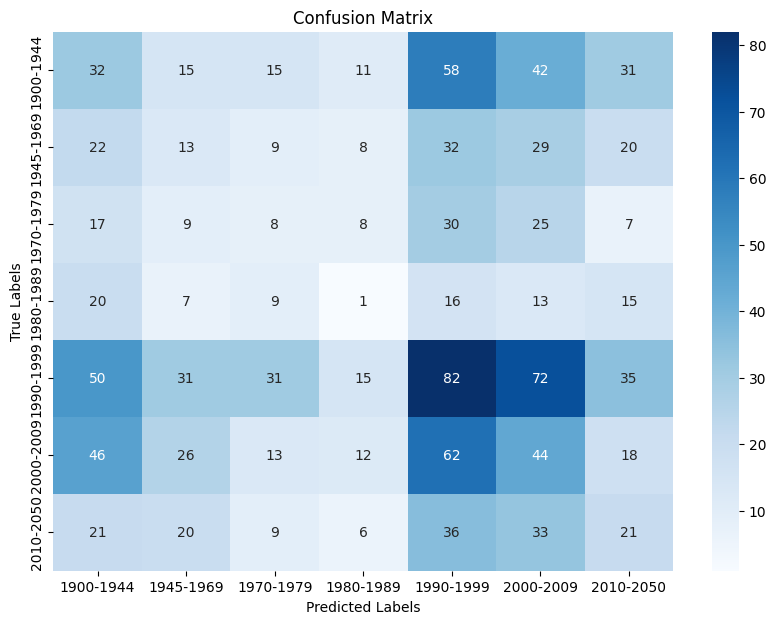

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming `true_classes` and `predicted_classes` are defined as before
cm = confusion_matrix(true_classes, predictions_stratified)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'], yticklabels=['1900-1944', '1945-1969', '1970-1979','1980-1989', '1990-1999', '2000-2009', '2010-2050'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()